In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants as const
from scipy.integrate import solve_ivp
import pandas as pd
from tabulate import tabulate

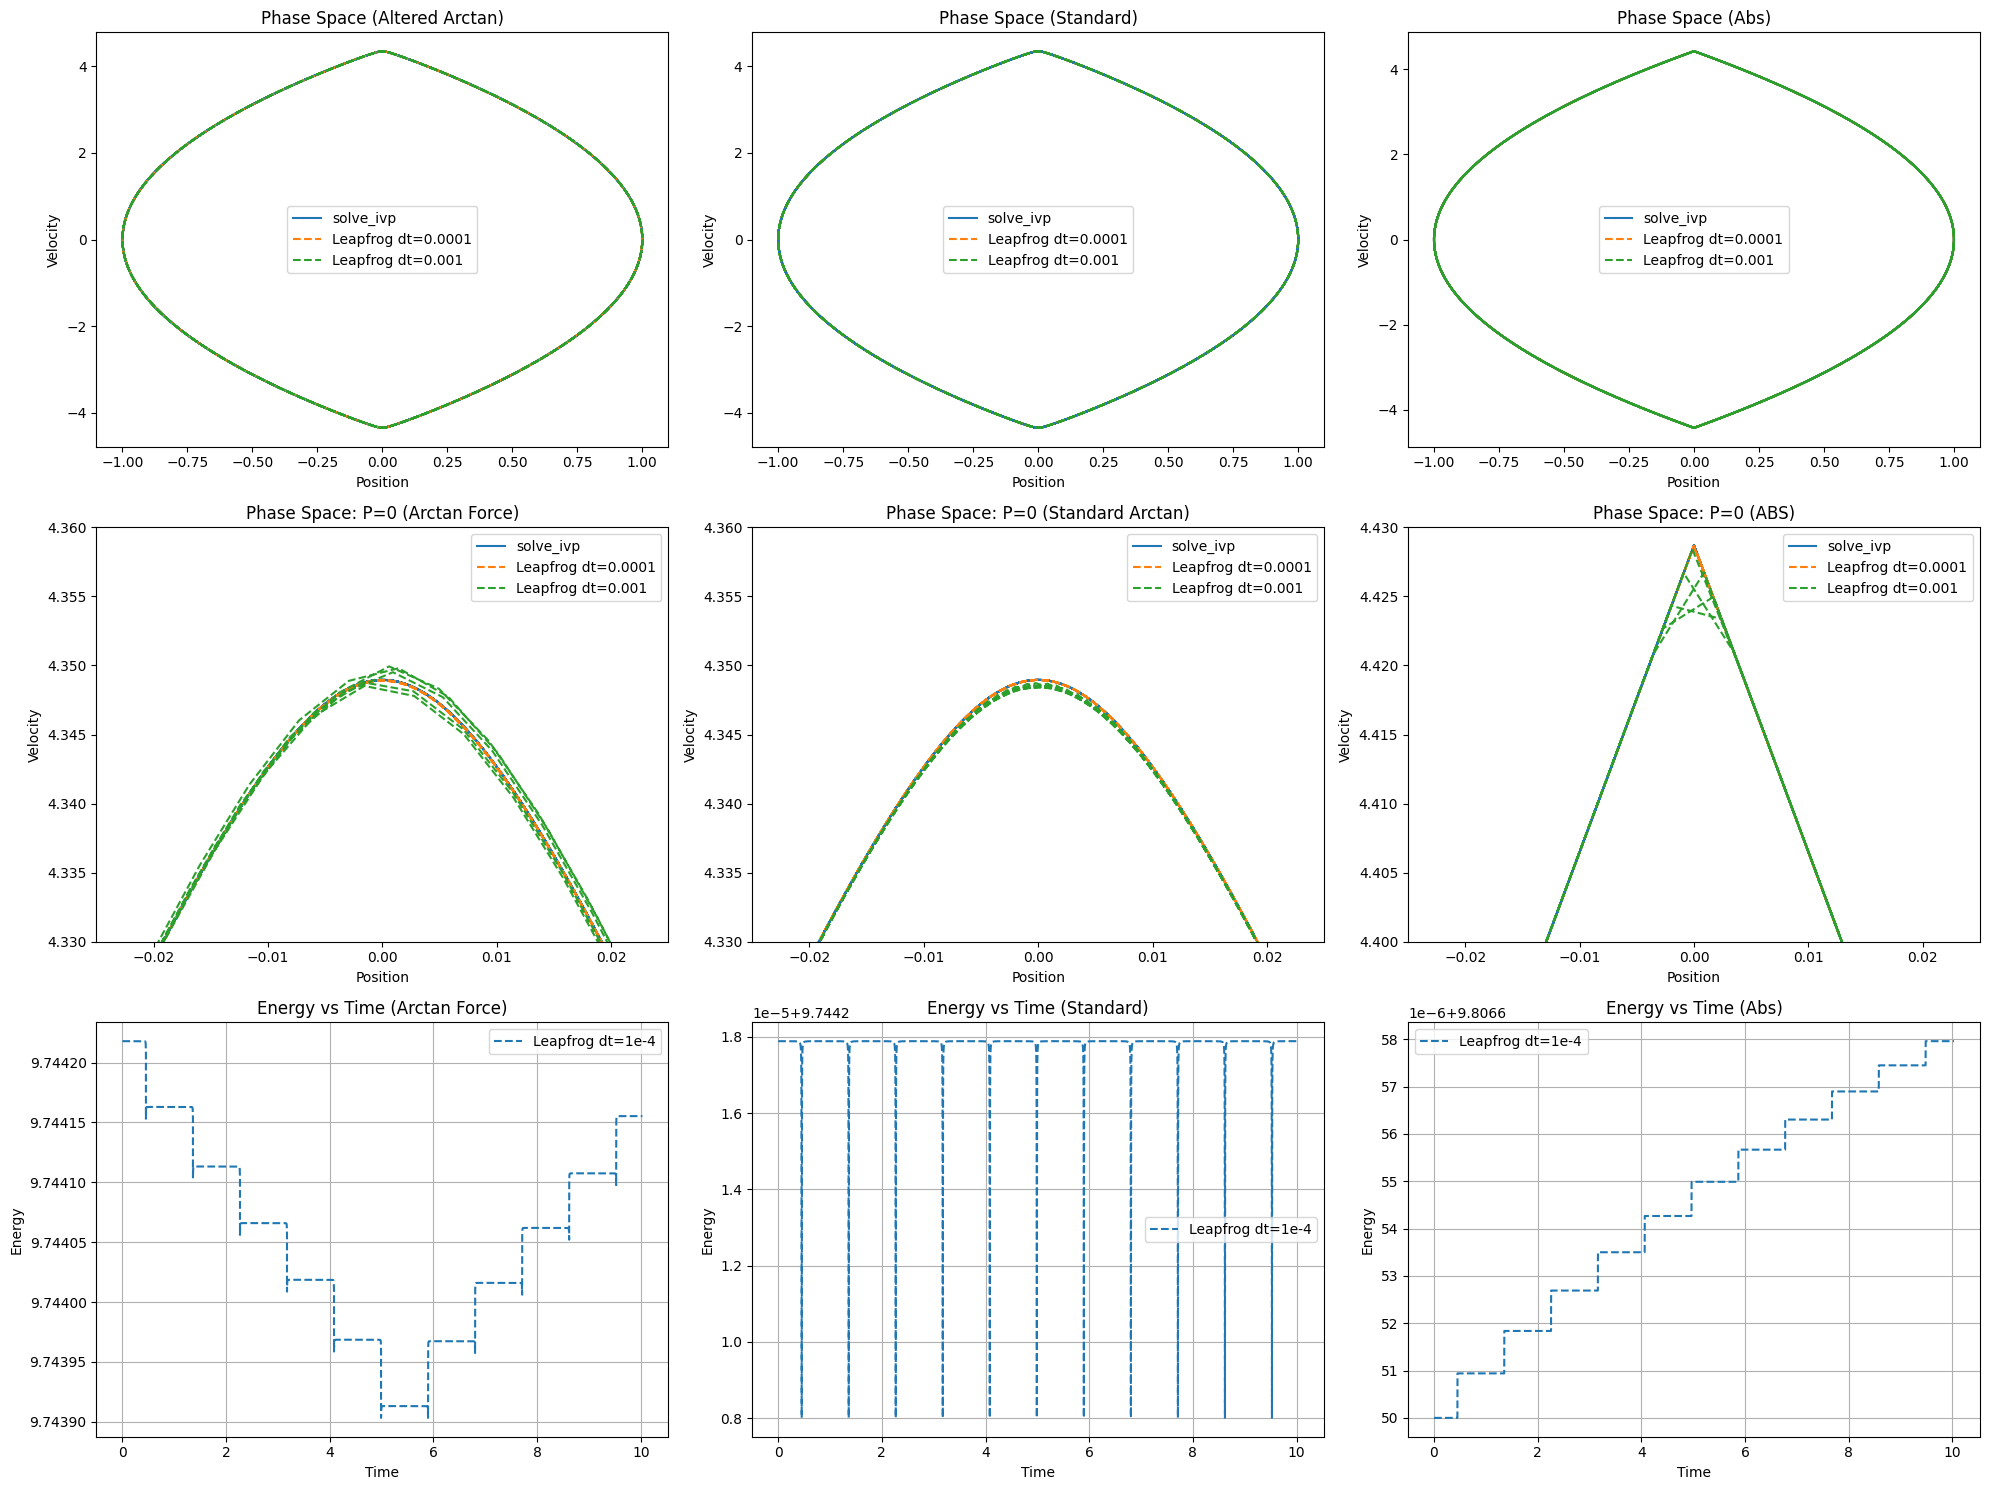

In [10]:
# Parameters
orbits = 5
x0 = 1
v0 = 0
T = 2 * np.pi * np.sqrt(x0/const.g) 
x_s = 0.01

# Force and energy functions
def create_force_arctan(x_s):
    return lambda x: -const.g * 2/np.pi * np.arctan(x/x_s)

def create_force_abs():
    return lambda x: -const.g * np.sign(x)

force_arctan = create_force_arctan(x_s)
force_abs = create_force_abs()

def total_energy_arctan(x, v, x_s):
    potential = -const.g / np.pi * (np.log(x**2 + x_s**2) * x_s - 2 * x * np.arctan(x/x_s))
    kinetic = 0.5 * v**2
    return kinetic + potential

def total_energy_abs(x, v):
    potential = const.g * np.abs(x)
    kinetic = 0.5 * v**2
    return kinetic + potential

# System functions for solve_ivp
def system_arctan(t, y):
    x, v = y
    return [v, force_arctan(x)]

def system_abs(t, y):
    x, v = y
    return [v, force_abs(x)]

# Numerical System Computing
def numerical_solution_arctan(x0, v0, x_s, force_arctan, dt, T, orbits):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)

    x = np.zeros(h)
    v = np.zeros(h)
    energy = np.zeros(h)

    x[0] = x0
    v[0] = v0
    energy[0] = total_energy_arctan(x[0], v[0], x_s)
    
    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_arctan(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_arctan(x[i+1])
        if x[i] * x[i+1] < 0:
            v[i+1] += -(x[i] + x[i+1])/(x[i+1]-x[i]) * dt * 0.5 * force_arctan(x[i])
            v[i+1] += (x[i+1]+x[i])/(x[i+1]-x[i]) * dt * 0.5 * force_arctan(x[i+1])
        energy[i+1] = total_energy_arctan(x[i+1], v[i+1],x_s)
    return t, x, v, energy

def numerical_solution_abs(x0, v0, force_abs, dt, T, orbits):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)

    x = np.zeros(h)
    v = np.zeros(h)
    energy = np.zeros(h)

    x[0] = x0
    v[0] = v0
    energy[0] = total_energy_abs(x[0], v[0])
    
    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_abs(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_abs(x[i+1])
        if x[i] * x[i+1] < 0:
            v[i+1] += -(x[i] + x[i+1])/(x[i+1]-x[i]) * dt * 0.5 * force_abs(x[i])
            v[i+1] += (x[i+1]+x[i])/(x[i+1]-x[i]) * dt * 0.5 * force_abs(x[i+1])
        energy[i+1] = total_energy_abs(x[i+1], v[i+1])
    return t, x, v, energy

def standard_leapfrog(x0, v0, force_arctan, dt, T, orbits):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    x = np.zeros(h)
    v = np.zeros(h)
    energy = np.zeros(h)
    x[0] = x0
    v[0] = v0
    energy[0] = total_energy_arctan(x[0], v[0], x_s)
    
    for i in range(h-1):
        v[i+1] = v[i] + 0.5 * dt * force_arctan(x[i])
        x[i+1] = x[i] + dt * v[i+1]
        v[i+1] = v[i+1] + 0.5 * dt * force_arctan(x[i+1])
        energy[i+1] = total_energy_arctan(x[i+1], v[i+1], x_s)
    return t, x, v, energy

dt = 1e-4
# Compute solutions
sol_arctan = solve_ivp(system_arctan, (0, orbits * T), [x0, v0], method='RK45', rtol=1e-10, atol=1e-10, max_step= dt)                      
t_ivp_arctan, x_ivp_arctan, v_ivp_arctan = sol_arctan.t, sol_arctan.y[0], sol_arctan.y[1]

sol_abs = solve_ivp(system_abs, (0, orbits * T), [x0, v0], method='RK45', rtol=1e-10, atol=1e-10, max_step = dt, )
t_ivp_abs, x_ivp_abs, v_ivp_abs = sol_abs.t, sol_abs.y[0], sol_abs.y[1]

stepsizes = [1e-4, 1e-3]
leapfrog_results_arctan = [numerical_solution_arctan(x0, v0, x_s, force_arctan, dt, T, orbits) for dt in stepsizes]
leapfrog_results_abs = [numerical_solution_abs(x0, v0, force_abs, dt, T, orbits) for dt in stepsizes]
leapfrog_standard = [standard_leapfrog(x0, v0, force_arctan, dt, T, orbits) for dt in stepsizes]

# Plotting
plt.figure(figsize=(20, 15))

#Arctan Plots
plt.subplot(3,3,1)
plt.plot(x_ivp_arctan, v_ivp_arctan, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_results_arctan):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Phase Space (Altered Arctan)')
plt.legend()

plt.subplot(3,3,4)
plt.plot(x_ivp_arctan, v_ivp_arctan, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_results_arctan):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.xlim(-0.025,0.025)
plt.ylim(4.330,4.360)
plt.title('Phase Space: P=0 (Arctan Force)')
plt.legend()

plt.subplot(3,3,7)
t, _, _, energy = leapfrog_results_arctan[0]
plt.plot(t, energy, label='Leapfrog dt=1e-4', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy vs Time (Arctan Force)')
plt.grid()
plt.legend()

#Standard Plots
plt.subplot(3,3,2)
plt.plot(x_ivp_arctan, v_ivp_arctan, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_standard):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Phase Space (Standard)')
plt.legend()

plt.subplot(3,3,5)
plt.plot(x_ivp_arctan, v_ivp_arctan, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_standard):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.xlim(-0.025,0.025)
plt.ylim(4.330,4.360)
plt.title('Phase Space: P=0 (Standard Arctan)')
plt.legend()

plt.subplot(3,3,8)
t, _, _, energy = leapfrog_standard[0]
plt.plot(t, energy, label='Leapfrog dt=1e-4', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy vs Time (Standard)')
plt.grid()
plt.legend()

#Abs Plot
plt.subplot(3,3,3)
plt.plot(x_ivp_abs, v_ivp_abs, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_results_abs):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.title('Phase Space (Abs)')
plt.legend()

plt.subplot(3,3,6)
plt.plot(x_ivp_abs, v_ivp_abs, label='solve_ivp')
for i, (_, x, v, _) in enumerate(leapfrog_results_abs):
    plt.plot(x, v, label=f'Leapfrog dt={stepsizes[i]}', linestyle='--')
plt.xlabel('Position')
plt.ylabel('Velocity')
plt.xlim(-0.025,0.025)
plt.ylim(4.400,4.430)
plt.title('Phase Space: P=0 (ABS)')
plt.legend()

plt.subplot(3,3,9)
t, _, _, energy = leapfrog_results_abs[0]
plt.plot(t, energy, label='Leapfrog dt=1e-4', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy vs Time (Abs)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
def analyze_bounce_dynamics(x0, v0, x_s, force_fn, dt, T, orbits, force_type="arctan", method="corrected"):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    
    bounce_data = []
    
    x = np.zeros(h)
    v = np.zeros(h)
    x[0] = x0
    v[0] = v0
    
    if force_type == "arctan":
        energy_fn = lambda x, v: total_energy_arctan(x, v, x_s)
    else:
        energy_fn = lambda x, v: total_energy_abs(x, v)
    
    bounce_count = 0
    
    for i in range(h-1):
        #Initial States
        v_initial = v[i]
        E_initial = energy_fn(x[i], v[i])
        
        # Standard leapfrog step
        v_temp = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v_temp
        v[i+1] = v_temp + 0.5 * dt * force_fn(x[i+1])
        
        # Check for bounce
        if x[i] * x[i+1] < 0:
            bounce_count += 1
            if bounce_count <= 10:  # Track only first 10 bounces
                if method == "standard":
                    # Standard leapfrog Data
                    bounce_data.append({
                        'bounce': bounce_count,
                        'dx': x[i+1] - x[i],
                        'dv': v[i+1] - v_initial,
                        'dE': energy_fn(x[i+1], v[i+1]) - E_initial,
                        'dt': dt
                    })
                else:
                    # State after first kick
                    v_after_kick1 = v[i+1] - (x[i] + x[i+1])/(x[i+1]-x[i]) * dt * 0.5 * force_fn(x[i])
                    
                    # State after second kick
                    v_final = v_after_kick1 + (x[i+1]+x[i])/(x[i+1]-x[i]) * dt * 0.5 * force_fn(x[i+1])
                    
                    # Record complete bounce data
                    bounce_data.append({
                        'bounce': bounce_count,
                        'dx': x[i+1] - x[i],
                        'dv_kick1': v_after_kick1 - v[i+1],
                        'dv_kick2': v_final - v_after_kick1,
                        'dv_total': v_final - v[i+1], 
                        'dv_bounce': v_final - v_initial,
                        'dE_kick1': energy_fn(x[i+1], v_after_kick1) - energy_fn(x[i+1], v[i+1]),
                        'dE_kick2': energy_fn(x[i+1], v_final) - energy_fn(x[i+1], v_after_kick1),
                        'dE_total': energy_fn(x[i+1], v_final) - energy_fn(x[i+1], v[i+1]), 
                        'dE_bounce': energy_fn(x[i+1], v_final) - E_initial,  
                        'dt': dt
                    })
                    v[i+1] = v_final
                
    return pd.DataFrame(bounce_data)

def format_summary(df, method="corrected"):
    if method == "standard":
        summary = df[['bounce', 'dx', 'dv', 'dE']].copy()
    else:
        summary = df[['bounce', 'dx', 'dv_kick1', 'dv_kick2', 'dv_total', 
                     'dv_bounce', 'dE_kick1', 'dE_kick2', 'dE_total', 
                     'dE_bounce']].copy()
    summary = summary.round(8)
    return summary.to_string(index=False)

# Analysis parameters
orbits = 10
x0 = 1
v0 = 0
T = 2 * np.pi * np.sqrt(x0/const.g)
x_s = 0.001

# Force functions
force_arctan = create_force_arctan(x_s)
force_abs = create_force_abs()

# Analyze both stepsizes for both force types and methods
stepsizes = [1e-4, 1e-3]
results = {}

for dt in stepsizes:
    # Standard leapfrog analysis for both force types
    results[f'standard_arctan_dt_{dt}'] = analyze_bounce_dynamics(
        x0, v0, x_s, force_arctan, dt, T, orbits, "arctan", "standard"
    )
    
    results[f'standard_abs_dt_{dt}'] = analyze_bounce_dynamics(
        x0, v0, x_s, force_abs, dt, T, orbits, "abs", "standard"
    )
    
    # Corrected leapfrog analysis
    results[f'arctan_dt_{dt}'] = analyze_bounce_dynamics(
        x0, v0, x_s, force_arctan, dt, T, orbits, "arctan", "corrected"
    )
    
    results[f'abs_dt_{dt}'] = analyze_bounce_dynamics(
        x0, v0, x_s, force_abs, dt, T, orbits, "abs", "corrected"
    )

# Print summaries
print(f"\nDetailed Bounce Analysis at x_s = {x_s}:")
for key, df in results.items():
    print(f"\nAnalysis for {key}:")
    if "standard" in key:
        print(format_summary(df, "standard"))
    else:
        print(format_summary(df, "corrected"))


Detailed Bounce Analysis at x_s = 0.001:

Analysis for standard_arctan_dt_0.0001:
 bounce        dx        dv       dE
      1 -0.000442  0.000130 0.000017
      2  0.000442 -0.000129 0.000017
      3 -0.000442  0.000128 0.000017
      4  0.000442 -0.000127 0.000017
      5 -0.000442  0.000127 0.000017
      6  0.000442 -0.000126 0.000017
      7 -0.000442  0.000125 0.000017
      8  0.000442 -0.000125 0.000017
      9 -0.000442  0.000124 0.000016
     10  0.000442 -0.000123 0.000016

Analysis for standard_abs_dt_0.0001:
 bounce        dx  dv        dE
      1 -0.000443 0.0  0.004278
      2  0.000443 0.0 -0.004278
      3 -0.000443 0.0  0.004278
      4  0.000443 0.0 -0.004278
      5 -0.000443 0.0  0.004278
      6  0.000443 0.0 -0.004278
      7 -0.000443 0.0  0.004278
      8  0.000443 0.0 -0.004278
      9 -0.000443 0.0  0.004278
     10  0.000443 0.0 -0.004278

Analysis for arctan_dt_0.0001:
 bounce        dx      dv_kick1      dv_kick2      dv_total  dv_bounce      dE_kick1  dE

In [37]:
def analyze_bounce_dynamics(x0, v0, x_s, force_fn, dt, T, orbits, force_type="arctan", method="corrected"):
    t_final = orbits * T
    h = int(t_final / dt) + 1
    t = np.linspace(0, t_final, h)
    
    bounce_data = []
    
    x = np.zeros(h)
    v = np.zeros(h)
    x[0] = x0
    v[0] = v0
    
    if force_type == "arctan":
        energy_fn = lambda x, v: total_energy_arctan(x, v, x_s)
    else:
        energy_fn = lambda x, v: total_energy_abs(x, v)
    
    bounce_count = 0
    
    for i in range(h-1):
        #Initial States
        v_initial = v[i]
        E_initial = energy_fn(x[i], v[i])
        
        # Standard leapfrog step
        v_temp = v[i] + 0.5 * dt * force_fn(x[i])
        x[i+1] = x[i] + dt * v_temp
        v[i+1] = v_temp + 0.5 * dt * force_fn(x[i+1])
        
        # Check for bounce
        if x[i] * x[i+1] < 0:
            bounce_count += 1
            if bounce_count <= 10:  # Track only first 10 bounces
                if method == "standard":
                    # Standard leapfrog Data
                    bounce_data.append({
                        'bounce': bounce_count,
                        'dx': x[i+1] - x[i],
                        'dv': v[i+1] - v_initial,
                        'dE': energy_fn(x[i+1], v[i+1]) - E_initial,
                        'dt': dt
                    })
                else:
                    # State after first kick
                    v_after_kick1 = v[i+1] - (x[i] + x[i+1])/(x[i+1]-x[i]) * dt * 0.5 * force_fn(x[i])
                    
                    # State after second kick
                    v_final = v_after_kick1 + (x[i+1]+x[i])/(x[i+1]-x[i]) * dt * 0.5 * force_fn(x[i+1])
                    
                    # Record complete bounce data
                    bounce_data.append({
                        'bounce': bounce_count,
                        'dx': x[i+1] - x[i],
                        'dv_kick1': v_after_kick1 - v[i+1],
                        'dv_kick2': v_final - v_after_kick1,
                        'dv_total': v_final - v[i+1], 
                        'dv_bounce': v_final - v_initial,
                        'dE_kick1': energy_fn(x[i+1], v_after_kick1) - energy_fn(x[i+1], v[i+1]),
                        'dE_kick2': energy_fn(x[i+1], v_final) - energy_fn(x[i+1], v_after_kick1),
                        'dE_total': energy_fn(x[i+1], v_final) - energy_fn(x[i+1], v[i+1]), 
                        'dE_bounce': energy_fn(x[i+1], v_final) - E_initial,  
                        'dt': dt
                    })
                    v[i+1] = v_final
                
    return pd.DataFrame(bounce_data)

def format_unified_summary(standard_df, corrected_df, force_type, dt):
    print(f"\nAnalysis for {force_type}_dt_{dt}:")
    
    # Standard method width: dx(14) + dv(14) + dE(14) = 42 + spacing(4) = 46
    # Corrected method width: dx(14) + dv_kick1(14) + dv_kick2(14) + dv_total(14) + dv_bounce(14) + 
    #                        dE_kick1(14) + dE_kick2(14) + dE_total(14) + dE_bounce(14) = 126 + spacing(16) = 142
    
    # Header lines
    print("       |{:^44}|{:^142}".format("Standard Method", "Corrected Method"))
    print("       |" + "-" * 44 + "|" + "-" * 126 + "|")
    print("       |{:>14}{:>14}{:>14}  |{:>14}{:>14}{:>14}{:>14}{:>14}{:>14}{:>14}{:>14}{:>14}|".format(
        "dx", "dv", "dE", "dx", "dv_kick1", "dv_kick2", "dv_total", "dv_bounce", 
        "dE_kick1", "dE_kick2", "dE_total", "dE_bounce"))
    print("-" * 179 + "|")
    
    # Format number to maintain consistent width and precision
    def format_num(x):
        return f"{x:14.6e}"
    
    # Combine and print results with consistent spacing
    for bounce in range(1, 11):
        std_row = standard_df[standard_df['bounce'] == bounce].iloc[0] if bounce <= len(standard_df) else None
        cor_row = corrected_df[corrected_df['bounce'] == bounce].iloc[0] if bounce <= len(corrected_df) else None
        
        if std_row is not None and cor_row is not None:
            print(f"{int(std_row['bounce']):6d} | "
                  f"{format_num(std_row['dx'])}{format_num(std_row['dv'])}{format_num(std_row['dE'])} |"
                  f"{format_num(cor_row['dx'])}{format_num(cor_row['dv_kick1'])}{format_num(cor_row['dv_kick2'])}"
                  f"{format_num(cor_row['dv_total'])}{format_num(cor_row['dv_bounce'])}{format_num(cor_row['dE_kick1'])}"
                  f"{format_num(cor_row['dE_kick2'])}{format_num(cor_row['dE_total'])}{format_num(cor_row['dE_bounce'])}")
    print("\n")


# Analysis parameters
orbits = 10
x0 = 1
v0 = 0
T = 2 * np.pi * np.sqrt(x0/const.g)
x_s = 0.001

# Force functions
force_arctan = create_force_arctan(x_s)
force_abs = create_force_abs()

# Analyze both stepsizes for both force types and methods
stepsizes = [1e-4, 1e-3]
results = {}

for dt in stepsizes:
    # Standard leapfrog analysis for both force types
    results[f'standard_arctan_dt_{dt}'] = analyze_bounce_dynamics(
        x0, v0, x_s, force_arctan, dt, T, orbits, "arctan", "standard"
    )
    
    results[f'standard_abs_dt_{dt}'] = analyze_bounce_dynamics(
        x0, v0, x_s, force_abs, dt, T, orbits, "abs", "standard"
    )
    
    # Corrected leapfrog analysis
    results[f'arctan_dt_{dt}'] = analyze_bounce_dynamics(
        x0, v0, x_s, force_arctan, dt, T, orbits, "arctan", "corrected"
    )
    
    results[f'abs_dt_{dt}'] = analyze_bounce_dynamics(
        x0, v0, x_s, force_abs, dt, T, orbits, "abs", "corrected"
    )

print(f"\nDetailed Bounce Analysis at x_s = {x_s}:")

for dt in stepsizes:
    # Arctan force comparison
    format_unified_summary(
        results[f'standard_arctan_dt_{dt}'],
        results[f'arctan_dt_{dt}'],
        'arctan',
        dt
    )
    
    # Abs force comparison
    format_unified_summary(
        results[f'standard_abs_dt_{dt}'],
        results[f'abs_dt_{dt}'],
        'abs',
        dt
    )


Detailed Bounce Analysis at x_s = 0.001:

Analysis for arctan_dt_0.0001:
       |              Standard Method               |                                                               Corrected Method                                                               
       |--------------------------------------------|------------------------------------------------------------------------------------------------------------------------------|
       |            dx            dv            dE  |            dx      dv_kick1      dv_kick2      dv_total     dv_bounce      dE_kick1      dE_kick2      dE_total     dE_bounce|
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
     1 |  -4.417506e-04  1.295096e-04  1.710717e-05 | -4.417506e-04  1.837740e-07  1.293472e-04  1.295310e-04  2.590406e-04 -8.117988e-07 -5.713671e-04 -5.721789e-04 -5.550717e-04
     2 